# Classification of Malware via Deep Learning

### Berkeley D. Willis


## Introduction

Malware has been around for decades, and depending on the writer and their goal will usually have different ways of achieving these goals. A few of these malware classification would include worms which just try to propogate and give access, spyware which watches the users and reports data back, or a Remote Access Tool (RAT). 

The question becomes how can this be possible through some basic static analysis, wihout having to get a human to necessarily get involved in the creation of features? Depending on the type of binary that is being analyzed, there is a large amount of data that is avaiable. 

For this particular project I am using Microsoft based data from a kaggle dataset that can be found [here](https://www.kaggle.com/muhammad4hmed/malwaremicrosoftbig). This data uses a lot raw datapoints that can be found statically, which means it could be somewhat easier to implement in a production like environment.



In [1]:
# First going to import all of the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Input, Flatten, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

import sklearn.model_selection as sk

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

In [2]:
# Now load the data and peak what some of the datapoints are
training_df = pd.read_csv("data/Dataset/Dataset/train/LargeTrain.csv")

display(training_df.head())
print("Data Shape: {}".format(training_df.shape))
# Quick peek at all of the columns and datapoints
print(training_df.columns[0:100])

,Virtual,Offset,loc,Import,Imports,var,Forwarder,UINT,LONG,BOOL,...,Img99,Img100,Img101,Img102,Img103,Img104,Img105,Img106,Img107,Class
0,3,3,689,18,6,890,6,39,17,88,...,35148.0,8687.0,55835.0,9078.0,21355.0,56302.0,10380.0,171979.0,162674.0,2
1,3,3,583,15,5,1574,5,6,7,30,...,571.0,718.0,1762.0,642.0,1820.0,1675.0,1100.0,7702.0,6551.0,8
2,3,4,2796,15,5,625,5,58,11,152,...,29872.0,16910.0,31708.0,9000.0,17586.0,30719.0,30062.0,55331.0,12946.0,9
3,3,3,373,27,9,615,9,16,10,34,...,10742.0,9755.0,26992.0,9069.0,24885.0,27108.0,13219.0,122247.0,98621.0,9
4,3,3,77,12,4,66,4,3,0,5,...,962.0,1307.0,3119.0,1172.0,3522.0,3245.0,2001.0,15501.0,11864.0,1


Data Shape: (10868, 1805)
Index(['Virtual', 'Offset', 'loc', 'Import', 'Imports', 'var', 'Forwarder',
       'UINT', 'LONG', 'BOOL', 'WORD', 'BYTES', 'large', 'short', 'dd', 'db',
       'dw', 'XREF', 'ptr', 'DATA', 'FUNCTION', 'extrn', 'byte', 'word',
       'dword', 'char', 'DWORD', 'stdcall', 'arg', 'locret', 'asc', 'align',
       'WinMain', 'unk', 'cookie', 'off', 'nullsub', 'DllEntryPoint',
       'System32', 'dll', 'CHUNK', 'BASS', 'HMENU', 'DLL', 'LPWSTR', 'void',
       'HRESULT', 'HDC', 'LRESULT', 'HANDLE', 'HWND', 'LPSTR', 'int', 'HLOCAL',
       'FARPROC', 'ATOM', 'HMODULE', 'WPARAM', 'HGLOBAL', 'entry', 'rva',
       'COLLAPSED', 'config', 'exe', 'Software', 'CurrentVersion', '__imp_',
       'INT_PTR', 'UINT_PTR', '---Seperator', 'PCCTL_CONTEXT', '__IMPORT_',
       'INTERNET_STATUS_CALLBACK', '.rdata:', '.data:', '.text:', 'misc_case',
       'misc_installdir', 'misc_market', 'misc_microsoft', 'misc_policies',
       'misc_proc', 'misc_scrollwindow', 'misc_search', 'misc

From what can be sen in the data is that it is very large with over a thousand different features, many that I am not sure would actually always be helpful, like possibly a count of the number of certain variables, or certain number of args. However, there are a good number of more helpful features lik the offset differences, and Microsoft libraries and functions that are being imported. 

All of these features are in numerical format, however the classes have a slight issue because there are technically 9 classes but they are numbered 1-9. So in order to make it work in deep learning modules in keras, they need to be reduced to 0-8 and hot-one-coded. 

In [3]:
# Splitting for training, validation, and testing data
x_train, x_test, y_train, y_test = sk.train_test_split(
    training_df[ training_df.columns[:-1] ],training_df[ training_df.columns[-1] ],
    test_size=0.33, random_state = 42)

In [4]:
y_train_coded = keras.utils.to_categorical(y_train-1, num_classes=9)
y_test_coded = keras.utils.to_categorical(y_test-1, num_classes=9)

# Going to set some other quick  variables that might be reused or changed during tuning
n_epochs = 100
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc1 = ModelCheckpoint('models/best_model1.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
mc2 = ModelCheckpoint('models/best_model2.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
mc3 = ModelCheckpoint('models/best_model3.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
mc4 = ModelCheckpoint('models/best_model4.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
mc5 = ModelCheckpoint('models/best_model5.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

# helper function to show history and metrics
def plot_metric(history, metric, base_title):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title("{} - {}".format(base_title, metric))
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [5]:
y_train_coded.shape

(7281, 9)

With these classes encoded we can create a couple of different models that are going to be needed. One type of layer from the keras library that is going to be required at somepoint will be Dense layers, because we have so many features and need to bring it down to 9 possible classes. 

The models are going to see how the addition of other dense layers would affect the outcome if we hold the n_epochs. Here I am thinking that obviously that the larger more layered networks can have more adjustments and take care of better generalization of the data. So I think the last one will be the best performing.

In [6]:
# Building dense network classifiers
model1 = Sequential()
model1.add(Input(shape=(1804,)))
model1.add(Dense(units=9, activation="softmax"))

model1.compile(optimizer='adam', 
              loss="categorical_crossentropy",
              metrics=['accuracy'])

print(model1.summary())



model2 = Sequential()
model2.add(Input(shape=(1804,)))
model2.add(Dense(units=64, activation="relu"))
model2.add(Dense(units=32, activation="relu"))
model2.add(Dense(units=9, activation="softmax"))

model2.compile(optimizer='adam', 
              loss="categorical_crossentropy",
              metrics=['accuracy'])

print(model2.summary())



model3 = Sequential()
model3.add(Input(shape=(1804,)))
model3.add(Dense(units=128, activation="relu"))
model3.add(Dense(units=64, activation="relu"))
model3.add(Dense(units=32, activation="relu"))
model3.add(Dense(units=9, activation="softmax"))

model3.compile(optimizer='adam', 
              loss="categorical_crossentropy",
              metrics=['accuracy'])

print(model3.summary())

model4 = Sequential()
model4.add(Input(shape=(1804,)))
model4.add(Dense(units=1024, activation="relu"))
model4.add(Dense(units=512, activation="relu"))
model4.add(Dense(units=256, activation="relu"))
model4.add(Dense(units=128, activation="relu"))
model4.add(Dense(units=64, activation="relu"))
model4.add(Dense(units=32, activation="relu"))
model4.add(Dense(units=9, activation="softmax"))

model4.compile(optimizer='adam', 
              loss="categorical_crossentropy",
              metrics=['accuracy'])

print(model4.summary())

# This time going to expand out the input
model5 = Sequential()
model5.add(Input(shape=(1804,)))
model5.add(Dense(units=2046, activation="relu"))
model5.add(Dense(units=1024, activation="relu"))
model5.add(Dense(units=512, activation="relu"))
model5.add(Dense(units=256, activation="relu"))
model5.add(Dense(units=128, activation="relu"))
model5.add(Dense(units=64, activation="relu"))
model5.add(Dense(units=32, activation="relu"))
model5.add(Dense(units=9, activation="softmax"))

model5.compile(optimizer='adam', 
              loss="categorical_crossentropy",
              metrics=['accuracy'])

print(model5.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9)                 16245     
Total params: 16,245
Trainable params: 16,245
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                115520    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 297       
Total params: 117,897
Trainable params: 117,897
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequen

With all of the models built and fully setup, going to start running them one by one.

Epoch 00042: early stopping


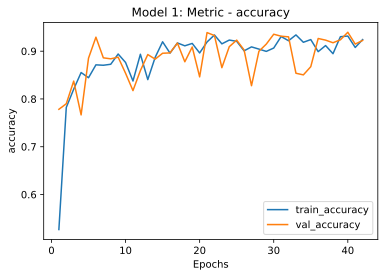

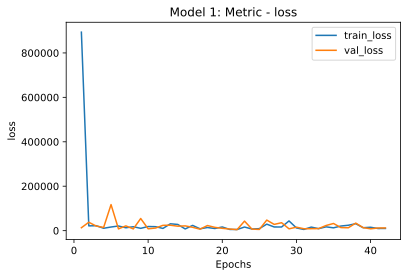

In [7]:
history1 = model1.fit(
    x_train, y_train_coded,
    epochs=n_epochs, validation_split=0.2, callbacks=[es, mc1], verbose=0)

# Now going to visualize the lines here
plot_metric(history1, "accuracy", "Model 1: Metric")
plot_metric(history1, "loss", "Model 1: Metric")

# Loading best version of this model
best_model1 = keras.models.load_model("models/best_model1.h5")

Epoch 00051: early stopping


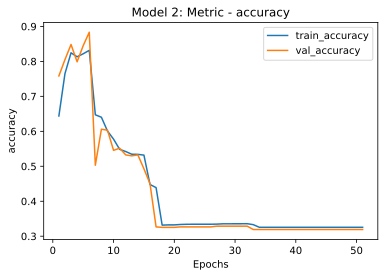

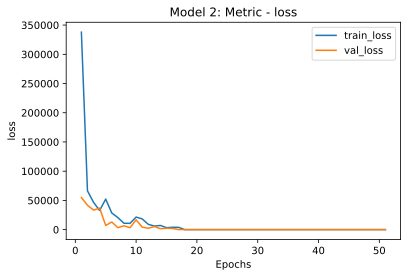

In [8]:
history2 = model2.fit(
    x_train, y_train_coded,
    epochs=n_epochs, validation_split=0.2, callbacks=[es, mc2], verbose=0)

# Now going to visualize the lines here
plot_metric(history2, "accuracy", "Model 2: Metric")
plot_metric(history2, "loss", "Model 2: Metric")

# Loading best version of this model
best_model2 = keras.models.load_model("models/best_model2.h5")

Epoch 00068: early stopping


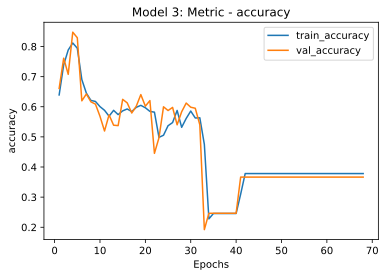

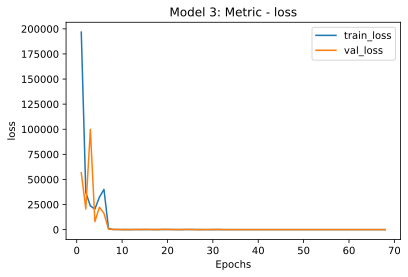

In [9]:
history3 = model3.fit(
    x_train, y_train_coded,
    epochs=n_epochs, validation_split=0.2, callbacks=[es, mc3], verbose=0)

plot_metric(history3, "accuracy", "Model 3: Metric")
plot_metric(history3, "loss", "Model 3: Metric")

# Loading best version of this model
best_model3 = keras.models.load_model("models/best_model3.h5")

Epoch 00087: early stopping


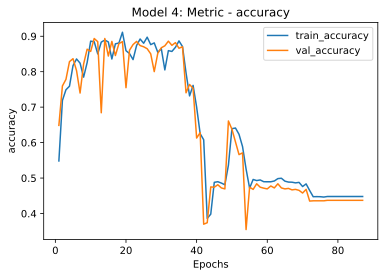

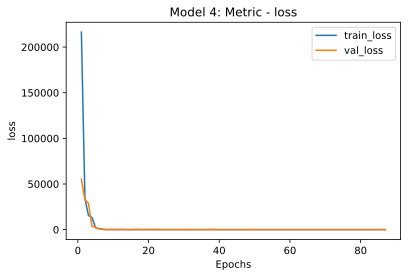

In [10]:
history4 = model4.fit(
    x_train, y_train_coded,
    epochs=n_epochs, validation_split=0.2, callbacks=[es, mc4], verbose=0)

plot_metric(history4, "accuracy", "Model 4: Metric")
plot_metric(history4, "loss", "Model 4: Metric")

# Loading best version of this model
best_model4 = keras.models.load_model("models/best_model4.h5")

Epoch 00070: early stopping


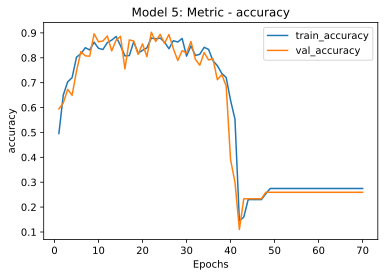

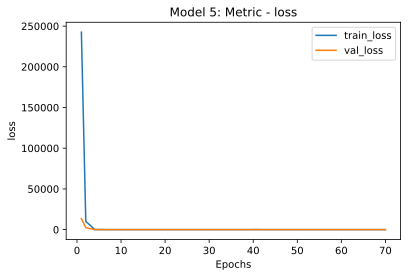

In [11]:
history5 = model5.fit(
    x_train, y_train_coded,
    epochs=n_epochs, validation_split=0.2, callbacks=[es, mc5], verbose=0)

plot_metric(history5, "accuracy", "Model 5: Metric")
plot_metric(history5, "loss", "Model 5: Metric")

# Loading best version of this model
best_model5 = keras.models.load_model("models/best_model5.h5")

Just as a quick note, the models that will be used in the final evaluations are going to be based on the best representation that was recorded during training. 

So now to get the full evaluations of the best for of each possible model.

In [12]:
# Running evaluation for each one
loss1, acc1 = best_model1.evaluate(x_test, y_test_coded)
loss2, acc2 = best_model2.evaluate(x_test, y_test_coded)
loss3, acc3 = best_model3.evaluate(x_test, y_test_coded)
loss4, acc4 = best_model4.evaluate(x_test, y_test_coded)
loss5, acc5 = best_model5.evaluate(x_test, y_test_coded)

loss_l = [loss1, loss2, loss3, loss4, loss5]
acc_l = [acc1, acc2, acc3, acc4, acc5]

results_df = pd.DataFrame({'loss':loss_l, 'acc':acc_l})

113/113 [==============================] - 1s 7ms/step - loss: 3.4726 - accuracy: 0.8921


In [13]:
display(results_df)

,loss,acc
0,9989.216797,0.942570
1,14895.929688,0.887929
2,9930.941406,0.864790
3,28.104568,0.904934
4,3.472593,0.892110


# Conclusion

Reviewing each one fo the networks, it seems that simplicity rules all once more, because the singular Dense network seemed to have performed the best out of all of them. As well it ran the shortest, ending earliest, and had the steadiest and stable climb up. 

This means that it is certainly possible to classify malware based off these various attributes using a rather simple Dense layer deep learning model. 

# Future Works

What I would hope in future works is that this deeper understanding of what is possiuble, and the attirbutes of these classes of malware. I also hope that this can lead to more stable and accurate models to identify malware before it is able to infect a computer, even if it is completely new before it can cause trouble.